# Introduction

In this problem set, we will be using XGB, LightGBM and CatBoost to predict customers' ability for loan repayment.

We have 3 different types of data:

1. Main data (application_train)
2. Home Credit (POS_CASH_balance, credit_card_balance, previous_application, installments_payments)
3. Credit Bureau (bureau, bureau_balance)

# Methodology

1. Initialise
2. EDA
3. Build ML Model
4. Further areas to explore/improve to improve our model

## Initialise

In [1]:
#Import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
%matplotlib inline

In [2]:
sample_sub = pd.read_csv('sample_submission.csv')

In [3]:
app_train = pd.read_csv('application_train.csv')

app_test = pd.read_csv('application_test.csv') 

#All client's previous credits provided by other financial 
#institutions that were reported to Credit Bureau
bur = pd.read_csv('bureau.csv')

#Monthly balances of previous credits in Credit Bureau
bur_bal = pd.read_csv('bureau_balance.csv')

#Monthly balance snapshots of previous POS (point of sales) and 
#cash loans that the applicant had with Home Credit. 
pos = pd.read_csv('POS_CASH_balance.csv')

#Monthly balance snapshots of previous credit cards 
#that the applicant has with Home Credit
cc_bal = pd.read_csv('credit_card_balance.csv')

#All previous applications for Home Credit 
#loans of clients who have loans in our sample
prev_app = pd.read_csv('previous_application.csv')

#Repayment history for the previously disbursed credits 
#in Home Credit related to the loans in our sample.
inst_pay = pd.read_csv('installments_payments.csv')

In [4]:
data = {'app_train' : app_train, 
        'app_test' : app_test,
        'bur' : bur,
        'bur_bal' : bur_bal,
        'pos' : pos,
        'cc_bal' : cc_bal,
        'prev_app': prev_app,
        'inst_pay' : inst_pay}

In [5]:
for i,j in data.items():
    print(f'{i}\n - shape - {j.shape}\n - percent of missing values - {round(sum(j.isnull().sum())/(j.shape[0]*j.shape[1]),3)}')

app_train
 - shape - (307511, 122)
 - percent of missing values - 0.244
app_test
 - shape - (48744, 121)
 - percent of missing values - 0.238
bur
 - shape - (1716428, 17)
 - percent of missing values - 0.135
bur_bal
 - shape - (27299925, 3)
 - percent of missing values - 0.0
pos
 - shape - (10001358, 8)
 - percent of missing values - 0.001
cc_bal
 - shape - (3840312, 23)
 - percent of missing values - 0.067
prev_app
 - shape - (1670214, 37)
 - percent of missing values - 0.18
inst_pay
 - shape - (13605401, 8)
 - percent of missing values - 0.0


There are a lot of missing / NaN values present in the dataset. This means there needs to be some sort of imputation to be done and not to just drop them (since we might remove valuable information).

In [6]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
app_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
bur.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [9]:
bur_bal.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [10]:
pos.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [11]:
cc_bal.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [12]:
inst_pay.head(5)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## EDA
1. Univariate Analysis
2. Feature Selection/Engineering for other tables
3. Bivariate Analysis
4. Outlier Treatment
5. Treating Missing Values
6. Feature Scaling
7. Encoding Categorical Variables

-------------------------------------------------------------------------

### Univariate Analysis


In [13]:
def univar_analysis(df):
    for i in df:
        if df[i].dtype == 'object': 
            sns.barplot(df[i].value_counts().index,df[i].value_counts())
            plt.title(i)
            plt.show()
        else:
            fig, ax = plt.subplots(1,2,figsize=(10,4))
            fig.tight_layout()
            ax[0].hist(df[i])
            ax[0].set_title(i)
            ax[1].boxplot(df[i])
            ax[1].set_title(i)
            plt.show()

In [14]:
# univar_analysis(app_train)

In [15]:
# univar_analysis(bur)

In [16]:
# univar_analysis(bur_bal)

In [17]:
# univar_analysis(pos)

In [18]:
# univar_analysis(cc_bal)

In [19]:
# univar_analysis(prev_app)

In [20]:
# univar_analysis(inst_pay)

#### Univariate Analysis Findings
We see that there are a few outliers in the data 
1. Total Income amount - 3 outliers (more than 10 million)
2. No of children - 10 outliers (10 or more children)

Some data do not make sense especially:
1. Days_Employed (very large positive values)



### Feature Selection/Engineering from other tables

We are doing feature selection/engineering for the other tables first to analyse how these features are associated with the Target variable.

#### From main table
1. Summed up all the documents to get total number of documents flagged / client submitted

#### Bureau:
Taking all the active credits, we can see several features that may be important:
1. Loan Status
2. Credit Type (Whether personal or business)
3. Remaining duration of CB credit
4. No. of times credits were prolonged
5. Credit Sum
6. Debt Amount
7. Credit Amount Overdue

#### Home Credit:
From POS:
1. Only taking active status
2. Term of previous credit
3. Installments left to pay on previous credit

From Credit Card Balance:
1. Not taking completed statuses
2. Amount of drawings
3. Total payment amount
4. Total receivable amount
5. No. of drawings

From Previous Applications:
1. Credit amount
2. Downpayment amount
3. Type of loan (split into consumer, cash and revolving loans)

From installment payments:
1. No. of days payment was delayed
2. Outstanding amount unpaid



In [21]:
#Bureau data
bur_tomerge = pd.DataFrame(bur_bal.groupby('SK_ID_BUREAU').MONTHS_BALANCE.max())
bur_tomerge = pd.merge(bur_tomerge,bur_bal,on=['SK_ID_BUREAU','MONTHS_BALANCE'],how='left')
bur_merged = pd.merge(bur,bur_tomerge[['SK_ID_BUREAU','STATUS']],on='SK_ID_BUREAU',how='left')
bur_merged.rename(columns={'STATUS':'LOAN STATUS'}, inplace=True)
bur_merged_drop = bur_merged[bur_merged['CREDIT_ACTIVE']=='Active']
bur_merged_drop['CREDIT_TYPE'].value_counts()
bur_merged_drop['CREDIT_PERSONAL'] = bur_merged_drop['CREDIT_TYPE'].apply(lambda x : 0 if x in {'Microloan','Loan for business development','Loan for working capital replenishment','Loan for the purchase of equipment','Loan for purchase of shares (margin lending)'} else 1)
bur_merged_drop['CREDIT_BUSINESS'] = bur_merged_drop['CREDIT_TYPE'].apply(lambda x : 1 if x in {'Microloan','Loan for business development','Loan for working capital replenishment','Loan for the purchase of equipment','Loan for purchase of shares (margin lending)'} else 0)
bur_merge_app = bur_merged_drop.groupby('SK_ID_CURR',as_index=False).agg({'DAYS_CREDIT_ENDDATE':mean,'CNT_CREDIT_PROLONG': sum, 'AMT_CREDIT_SUM' : sum, 'AMT_CREDIT_SUM_DEBT':sum, 'AMT_CREDIT_SUM_OVERDUE':sum,'CREDIT_PERSONAL':sum,'CREDIT_BUSINESS':sum})
bur_merge_app.rename(columns={'DAYS_CREDIT_ENDDATE' : 'BUR_DAYS_CREDIT_ENDDATE'},inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [22]:
#POS data
pos_filter = pos[(pos['NAME_CONTRACT_STATUS'] != 'Completed') | (pos['NAME_CONTRACT_STATUS'] != 'Canceled') | (pos['NAME_CONTRACT_STATUS'] != 'XNA')]
pos_tomerge = pos_filter.groupby('SK_ID_CURR',as_index=False).agg({'CNT_INSTALMENT':mean,'CNT_INSTALMENT_FUTURE':mean})

In [23]:
#Credit card balance data
cc_bal_filter = cc_bal[(cc_bal['NAME_CONTRACT_STATUS'] != 'Completed') | (cc_bal['NAME_CONTRACT_STATUS'] != 'Refused')]
cc_bal_merge_app = cc_bal_filter.groupby('SK_ID_CURR',as_index=False).agg({'AMT_DRAWINGS_CURRENT':sum,'AMT_PAYMENT_TOTAL_CURRENT':sum,'AMT_TOTAL_RECEIVABLE':sum,'CNT_DRAWINGS_CURRENT':mean})

In [24]:
#Previous application data
prev_app_filter = prev_app[(prev_app['NAME_CONTRACT_STATUS'] == 'Approved')&(prev_app['NAME_CONTRACT_TYPE'] != 'XNA')]
prev_app_filter['PREV_TYPE_CONSUMER_LOAN'] = prev_app_filter['NAME_CONTRACT_TYPE'].apply(lambda x: 1 if x == 'Consumer loans' else 0)
prev_app_filter['PREV_TYPE_CASH_LOAN'] = prev_app_filter['NAME_CONTRACT_TYPE'].apply(lambda x: 1 if x == 'Cash loans' else 0)
prev_app_filter['PREV_TYPE_REVOLVING_LOAN'] = prev_app_filter['NAME_CONTRACT_TYPE'].apply(lambda x: 1 if x == 'Revolving loans' else 0)
prev_app_merge_app = prev_app_filter.groupby('SK_ID_CURR',as_index=False).agg({'AMT_CREDIT': mean,'AMT_DOWN_PAYMENT': mean, 'PREV_TYPE_CONSUMER_LOAN' : sum, 'PREV_TYPE_CASH_LOAN':sum, 'PREV_TYPE_REVOLVING_LOAN':sum})
prev_app_merge_app.rename(columns={'AMT_CREDIT': 'PREV_AMT_CREDIT','AMT_DOWN_PAYMENT' : 'PREV_AMT_DOWNPAYMENT'},inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [25]:
#Even though this might be an important feature, there is more than 50% missing data, hence we will not use this 
prev_app['NAME_SELLER_INDUSTRY'].value_counts()

XNA                     855720
Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: NAME_SELLER_INDUSTRY, dtype: int64

In [26]:
#Installment payment data
inst_pay['DAYS_DELAY_PAYMENT'] = inst_pay['DAYS_ENTRY_PAYMENT']-inst_pay['DAYS_INSTALMENT']
inst_pay['OUTSTANDING_AMOUNT_UNPAID'] = inst_pay['AMT_INSTALMENT'] - inst_pay['AMT_PAYMENT']
inst_pay_tomerge = inst_pay.groupby('SK_ID_CURR',as_index=False).agg({'DAYS_DELAY_PAYMENT': mean,'OUTSTANDING_AMOUNT_UNPAID':sum})

In [27]:
#Merge with main table
flag_docs = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
app_train['NUM_DOC'] = app_train.apply(lambda x: int(x['FLAG_DOCUMENT_2'])+int(x['FLAG_DOCUMENT_3'])+int(x['FLAG_DOCUMENT_4'])+int(x['FLAG_DOCUMENT_5'])+int(x['FLAG_DOCUMENT_6'])+int(x['FLAG_DOCUMENT_7'])+int(x['FLAG_DOCUMENT_8'])+int(x['FLAG_DOCUMENT_9'])+int(x['FLAG_DOCUMENT_10'])+int(x['FLAG_DOCUMENT_11'])+int(x['FLAG_DOCUMENT_12'])+int(x['FLAG_DOCUMENT_13'])+int(x['FLAG_DOCUMENT_14'])+int(x['FLAG_DOCUMENT_15'])+int(x['FLAG_DOCUMENT_16'])+int(x['FLAG_DOCUMENT_17'])+int(x['FLAG_DOCUMENT_18'])+int(x['FLAG_DOCUMENT_19'])+int(x['FLAG_DOCUMENT_20'])+int(x['FLAG_DOCUMENT_21']),axis=1)
app_train.drop(columns=flag_docs,inplace=True)
app_train_merge = pd.merge(app_train,bur_merge_app,how='left',on='SK_ID_CURR')
app_train_merge = pd.merge(app_train_merge,pos_tomerge,how='left',on='SK_ID_CURR')
app_train_merge = pd.merge(app_train_merge,cc_bal_merge_app,how='left',on='SK_ID_CURR')
app_train_merge = pd.merge(app_train_merge,prev_app_merge_app,how='left',on='SK_ID_CURR')

In [28]:
#Merging main test table
app_test['NUM_DOC'] = app_test.apply(lambda x: int(x['FLAG_DOCUMENT_2'])+int(x['FLAG_DOCUMENT_3'])+int(x['FLAG_DOCUMENT_4'])+int(x['FLAG_DOCUMENT_5'])+int(x['FLAG_DOCUMENT_6'])+int(x['FLAG_DOCUMENT_7'])+int(x['FLAG_DOCUMENT_8'])+int(x['FLAG_DOCUMENT_9'])+int(x['FLAG_DOCUMENT_10'])+int(x['FLAG_DOCUMENT_11'])+int(x['FLAG_DOCUMENT_12'])+int(x['FLAG_DOCUMENT_13'])+int(x['FLAG_DOCUMENT_14'])+int(x['FLAG_DOCUMENT_15'])+int(x['FLAG_DOCUMENT_16'])+int(x['FLAG_DOCUMENT_17'])+int(x['FLAG_DOCUMENT_18'])+int(x['FLAG_DOCUMENT_19'])+int(x['FLAG_DOCUMENT_20'])+int(x['FLAG_DOCUMENT_21']),axis=1)
app_test.drop(columns=flag_docs,inplace=True)
app_test_merge = pd.merge(app_test,bur_merge_app,how='left',on='SK_ID_CURR')
app_test_merge = pd.merge(app_test_merge,pos_tomerge,how='left',on='SK_ID_CURR')
app_test_merge = pd.merge(app_test_merge,cc_bal_merge_app,how='left',on='SK_ID_CURR')
app_test_merge = pd.merge(app_test_merge,prev_app_merge_app,how='left',on='SK_ID_CURR')

### Data Cleaning

1. Check for time-relative data, whether there are any positive values (do they make sense)
2. Gender data contains NA data
3. Days employed has weird looking data (positive values)

In [29]:
i=['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH','DAYS_REGISTRATION']
for x in i:
    p=app_train_merge[app_train_merge[x]>0].shape
    print(f'x - {p}')

x - (0, 121)
x - (55374, 121)
x - (0, 121)
x - (0, 121)


In [30]:
md = int(app_train_merge[app_train_merge['DAYS_EMPLOYED']<0]['DAYS_EMPLOYED'].median())
def data_clean(df, md):
    #remove gender XNA
    df.drop(df.loc[app_train_merge['CODE_GENDER']=='XNA'].index,inplace=True)
    
    #Impute data with median since dropping it would mean a lot of our data would be dismissed
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: md if x > 0 else x) 

data_clean(app_train_merge,md)

### Bivariate Analysis

We will compare all the data and see its association with the target variable ('Target'). 
Performing the follow:
1. Chi-square tests for categorical variables, and
2. Point biserial correlation for continuous / interval variables 

This will give us a good indication quantiatively whether these variables have associations with the target variable.

Since we are using XGB, LightGBM and CatBoost, multicollinearity is not an issue we have to deal with.

In [31]:
app_train_merge.corrwith(app_train['TARGET']).sort_values(ascending=False)

TARGET                         1.000000
CNT_DRAWINGS_CURRENT           0.082520
DAYS_BIRTH                     0.078242
DAYS_EMPLOYED                  0.063366
REGION_RATING_CLIENT_W_CITY    0.060895
                                 ...   
FLOORSMAX_MEDI                -0.043773
FLOORSMAX_AVG                 -0.044009
EXT_SOURCE_1                  -0.155317
EXT_SOURCE_2                  -0.160471
EXT_SOURCE_3                  -0.178926
Length: 105, dtype: float64

In [32]:
# #Visualisation for categorical data
# app_train_merge_0 = app_train_merge[app_train_merge['TARGET'] == 0]
# app_train_merge_1 = app_train_merge[app_train_merge['TARGET'] == 1]
# for i in app_train_merge:
#     if app_train_merge[i].dtype == 'object':
#         fig, axes = plt.subplots(1,2,figsize=(16,6))
#         pd.crosstab(app_train_merge_0['TARGET'],app_train_merge_0[i]).plot(kind='bar',ax=axes[0])
#         pd.crosstab(app_train_merge_1['TARGET'],app_train_merge_1[i]).plot(kind='bar',ax=axes[1])

In [42]:
#Preparation for chi square test
cat_col = []
for i in app_train_merge:
    if app_train_merge[i].dtype == 'int' or app_train_merge[i].dtype == 'object' or app_train_merge[i].name == 'TARGET':
        cat_col.append(i)
app_train_merge[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH']]

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH
0,-9461,-637,-2120
1,-16765,-1188,-291
2,-19046,-225,-2531
3,-19005,-3039,-2437
4,-19932,-3038,-3458
...,...,...,...
307506,-9327,-236,-1982
307507,-20775,-1648,-4090
307508,-14966,-7921,-5150
307509,-11961,-4786,-931


In [43]:
cat_col

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'NUM_DOC']

In [44]:
app_train_cat = app_train_merge[cat_col].drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH'])
chi2_summary = []
for i in app_train_cat:
    (chi2, p, dof,_) = chi2_contingency(pd.crosstab(app_train_cat['TARGET'],app_train_cat[i]))
    score_to_add = {}
    score_to_add['var'] = i
    score_to_add['chi_square_stat'] = chi2
    score_to_add['p-value'] = p
    score_to_add['dof'] = dof
    chi2_summary.append(score_to_add)
df_chi2 = pd.DataFrame(chi2_summary)
df_chi2

,var,chi_square_stat,p-value,dof
0,SK_ID_CURR,307507.000000,4.991522e-01,307506
1,TARGET,307493.525339,0.000000e+00,1
2,NAME_CONTRACT_TYPE,292.957676,1.127500e-65,1
3,CODE_GENDER,920.005725,4.394091e-202,1
4,FLAG_OWN_CAR,146.639147,9.410574e-34,1
5,FLAG_OWN_REALTY,11.566092,6.716542e-04,1
6,CNT_CHILDREN,185.468398,5.021895e-32,14
7,NAME_TYPE_SUITE,32.819065,1.136071e-05,6
8,NAME_INCOME_TYPE,1253.551805,1.851917e-266,7
9,NAME_EDUCATION_TYPE,1019.200873,2.462768e-219,4


In [45]:
# #Visualisation for continuous variables
# for i in app_train_merge:
#     if app_train_merge[i].dtype == 'float' or i in ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH']:
#         plt.show()
#         sns.boxplot(x='TARGET',y=i,data=app_train_merge)
#         plt.title(i)
#         plt.show()

In [46]:
#Preparation for Point biserial correlation
num_col = []
for i in app_train_merge:
    if app_train_merge[i].dtype == 'float' or i in ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH'] or app_train[i].name == 'TARGET':
        num_col.append(i)

#### Missing values for Point Biserial Correlation
1. To take into account for outliers, we will impute with median for now to run the correlation
2. We know that this is not super accurate in terms of correlation, but NA values will disregard a lot of the data, hence imputing with median will  introduce bias into the data. 
3. We will use median imputation since dropping the values will too much of the data (3% of the data is left)


In [48]:
num_col

['TARGET',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEV

In [49]:
app_train_num = app_train_merge[num_col]
imputer = SimpleImputer(missing_values=np.nan,strategy='median')
imputer.fit(app_train_num.iloc[:,:app_train_num.shape[1]])
(app_train_num.iloc[:,:app_train_num.shape[1]]) = imputer.transform(app_train_num.iloc[:,:app_train_num.shape[1]])

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [50]:
app_train_num['TARGET']

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    1.0
307510    0.0
Name: TARGET, Length: 307507, dtype: float64

In [51]:
#Point biserial correlation
#Normally distributed, No outliers, equal variances between the two target points
from scipy.stats import pearsonr, pointbiserialr
num_summary = []
for i in app_train_num:
    pbs = pointbiserialr(app_train_num[i],app_train_num['TARGET'])
    score_to_add = {}
    score_to_add['var'] = i
    score_to_add['pbs corr'] = pbs[0]
    score_to_add['pbs p-value'] = pbs[1]
    num_summary.append(score_to_add)
df_num = pd.DataFrame(num_summary)
df_num

,var,pbs corr,pbs p-value
0,TARGET,1.000000,0.000000e+00
1,AMT_INCOME_TOTAL,-0.003982,2.725012e-02
2,AMT_CREDIT,-0.030371,1.128335e-63
3,AMT_ANNUITY,-0.012817,1.181182e-12
4,AMT_GOODS_PRICE,-0.039625,4.306671e-107
...,...,...,...
82,PREV_AMT_CREDIT,-0.023750,1.270338e-39
83,PREV_AMT_DOWNPAYMENT,-0.015515,7.690163e-18
84,PREV_TYPE_CONSUMER_LOAN,-0.034248,1.808723e-80
85,PREV_TYPE_CASH_LOAN,-0.011895,4.211529e-11


#### Taking 1% significance level for both chi square and point biserial

In [52]:
df_chi2[df_chi2['p-value'] <0.01]

,var,chi_square_stat,p-value,dof
1,TARGET,307493.525339,0.000000e+00,1
2,NAME_CONTRACT_TYPE,292.957676,1.127500e-65,1
3,CODE_GENDER,920.005725,4.394091e-202,1
4,FLAG_OWN_CAR,146.639147,9.410574e-34,1
5,FLAG_OWN_REALTY,11.566092,6.716542e-04,1
6,CNT_CHILDREN,185.468398,5.021895e-32,14
7,NAME_TYPE_SUITE,32.819065,1.136071e-05,6
8,NAME_INCOME_TYPE,1253.551805,1.851917e-266,7
9,NAME_EDUCATION_TYPE,1019.200873,2.462768e-219,4
10,NAME_FAMILY_STATUS,504.701120,7.717800e-107,5


In [53]:
#Even though total income was not statiscally significant at 1%, we know qualitatively that this feature is an important factor to predict loan repayment
df_num[(df_num['pbs p-value']<0.01) | df_num['var'] == 'AMT_INCOME_TOTAL']

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,var,pbs corr,pbs p-value


#### Findings from bivariate analysis

Statistical testing/correlations done did not reduce our dimensionality by a lot. We will use these variables and put into the model. Further analysis will be done after different runs of the model.

### Outlier Treatment

Treating the following variables:
1. Children count
2. Total income
3. Sum of credit amount

We will pass into the model two difference data tables
1. One with outlier treatment
2. One without outlier treatment

This is because these outliers might be a good indication and actual data that could be valuable for the model to train on.

In [54]:
#Since these outlier variables account for less than 1% of the data, we can drop them
def outlier_treatment(df):
    df.drop(df.loc[df['CNT_CHILDREN']>10].index,inplace=True)
    df.drop(df.loc[df['AMT_INCOME_TOTAL']>1000000].index,inplace=True)
    df.drop(df.loc[df['AMT_CREDIT_SUM']>=270104026.5].index,inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe2a5ab2150>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe2a5ab2c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe2a5aad4d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe2a5abb690>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe2a5abbb90>],
 'means': []}

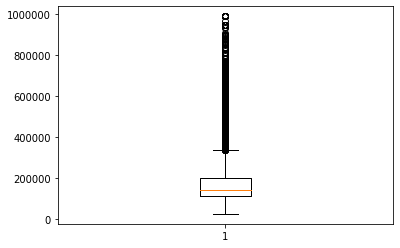

In [55]:
app_train_merge_outlier = app_train_merge.copy()
outlier_treatment(app_train_merge_outlier)
plt.boxplot(app_train_merge_outlier['AMT_INCOME_TOTAL'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe2a1cb1d10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe2a1cac790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe2a1cb10d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe2a1cb1dd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe2a1ca6710>],
 'means': []}

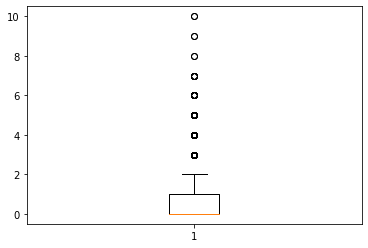

In [56]:
plt.boxplot(app_train_merge_outlier['CNT_CHILDREN'])

In [57]:
#inputting relevant columns into the application training data
columns = list(df_num['var']) + list(df_chi2['var'])
columns.remove('TARGET')
app_train_merge = app_train_merge[columns]
app_train_merge_outlier = app_train_merge_outlier[columns]

### Treating Missing Values

We will analyse the missing values and see how to impute them accordingly

In [58]:
p = []
for k in app_train_merge:
    if app_train_merge[k].isnull().any().sum() == True:
        p.append(k)
p

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMEN

In [59]:
fill_mean = ['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI']
fill_median = ['AMT_ANNUITY',
 'AMT_GOODS_PRICE','OWN_CAR_AGE','OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'BUR_DAYS_CREDIT_ENDDATE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_OVERDUE','CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'AMT_DRAWINGS_CURRENT',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_CURRENT',
 'PREV_AMT_CREDIT',
 'PREV_AMT_DOWNPAYMENT',
               
 'AMT_CREDIT_SUM_DEBT',
 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'YEARS_BEGINEXPLUATATION_MODE'
]
fill_mode = ['OCCUPATION_TYPE','CNT_FAM_MEMBERS','CREDIT_PERSONAL',
 'CREDIT_BUSINESS','PREV_TYPE_CONSUMER_LOAN',
 'PREV_TYPE_CASH_LOAN', 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE', 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'PREV_TYPE_REVOLVING_LOAN',
 'NAME_TYPE_SUITE']

#### When filling in missing values, in the real world it makes sense to impute numbers derived from the training data, to impute missing values for the test data

In [60]:
def fill_null(df,df_compute,fill_mean,fill_median,fill_mode):   
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
    imputer.fit(df_compute[fill_mean])
    df[fill_mean] = imputer.transform(df[fill_mean])
    
    imputer = SimpleImputer(missing_values=np.nan,strategy='median')
    imputer.fit(df_compute[fill_median])
    df[fill_median] = imputer.transform(df[fill_median])
    
    imputer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    imputer.fit(df_compute[fill_mode])
    df[fill_mode] = imputer.transform(df[fill_mode])

In [61]:
#impute nulls
fill_null(app_train_merge,app_train_merge,fill_mean,fill_median,fill_mode)
fill_null(app_train_merge_outlier,app_train_merge_outlier,fill_mean,fill_median,fill_mode)

app_test_merge_outlier = app_test_merge.copy()
fill_null(app_test_merge,app_train_merge,fill_mean,fill_median,fill_mode)
fill_null(app_test_merge_outlier,app_train_merge_outlier,fill_mean,fill_median,fill_mode)

In [62]:
app_train_merge['TARGET']

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307507, dtype: int64

### Feature Scaling
Two different types of feature scaling according to the distribution of each variable:
1. Normalisation
2. Standardisation

In [63]:
#Split X and y variables
columns = list(df_num['var']) + list(df_chi2['var'])
columns.remove('TARGET')

app_train_merge = app_train_merge[columns]
app_train_merge_outlier = app_train_merge_outlier[columns]

X_train = app_train_merge.drop(columns='TARGET')
X_train_outlier =app_train_merge_outlier.drop(columns='TARGET')
y_train = app_train_merge['TARGET']
y_train_outlier = app_train_merge_outlier['TARGET']

columns.remove('TARGET')
X_test  = app_test_merge[columns]
X_test_outlier = app_test_merge_outlier[columns]

In [64]:
# for i in X_train_outlier[columns]: 
#     if X_train_outlier[i].dtype == 'object':
#         sns.barplot(X_train_outlier[i].value_counts().index,X_train_outlier[i].value_counts())
#         plt.title(i)
#         plt.show()
    
#     else:
#         fig, ax = plt.subplots(1,2,figsize=(10,4))
#         fig.tight_layout()
#         ax[0].hist(X_train_outlier[i])
#         ax[0].set_title(i)
#         ax[1].boxplot(X_train_outlier[i])
#         ax[1].set_title(i)
#         plt.show()

In [65]:
# for i in X_train[columns]: 
#     if X_train[i].dtype == 'object':
#         sns.barplot(X_train[i].value_counts().index,X_train[i].value_counts())
#         plt.title(i)
#         plt.show()
    
#     else:
#         fig, ax = plt.subplots(1,2,figsize=(10,4))
#         fig.tight_layout()
#         ax[0].hist(X_train[i])
#         ax[0].set_title(i)
#         ax[1].boxplot(X_train[i])
#         ax[1].set_title(i)
#         plt.show()

In [66]:
to_normalise = ['OWN_CAR_AGE','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_PAYMENT_TOTAL_CURRENT',
                'AMT_REQ_CREDIT_BUREAU_DAY','OBS_60_CNT_SOCIAL_CIRCLE',
                'DEF_30_CNT_SOCIAL_CIRCLE','CREDIT_PERSONAL','NUM_DOC','PREV_AMT_CREDIT',
                'AMT_REQ_CREDIT_BUREAU_QRT','PREV_TYPE_REVOLVING_LOAN',
                'AMT_CREDIT_SUM_OVERDUE','PREV_AMT_DOWNPAYMENT','CNT_CREDIT_PROLONG',
                'AMT_TOTAL_RECEIVABLE','CREDIT_BUSINESS','AMT_DRAWINGS_CURRENT','AMT_REQ_CREDIT_BUREAU_HOUR', 
                'BUR_DAYS_CREDIT_ENDDATE','OBS_30_CNT_SOCIAL_CIRCLE','CNT_DRAWINGS_CURRENT','AMT_CREDIT_SUM',
                'DAYS_LAST_PHONE_CHANGE','REGION_RATING_CLIENT','PREV_TYPE_CONSUMER_LOAN',
                'AMT_REQ_CREDIT_BUREAU_MON']
to_standardise = ['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
                  'AMT_CREDIT_SUM_DEBT',
                  'HOUR_APPR_PROCESS_START','REGION_POPULATION_RELATIVE','CNT_FAM_MEMBERS',
                  'AMT_ANNUITY','CNT_INSTALMENT','AMT_CREDIT','AMT_REQ_CREDIT_BUREAU_YEAR',
                  'DAYS_EMPLOYED','CNT_CHILDREN','CNT_INSTALMENT_FUTURE','DAYS_ID_PUBLISH',
                  'AMT_GOODS_PRICE','AMT_INCOME_TOTAL','DAYS_REGISTRATION']

In [67]:
def normalisation(df_train,df_test,sc,to_normalise):
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler()
    df_train.loc[:,to_normalise] = sc.fit_transform(df_train.loc[:,to_normalise])
    df_test.loc[:,to_normalise] = sc.transform(df_test.loc[:,to_normalise])
    
def standardisation(df_train,df_test,sc,to_standardise):
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    df_train.loc[:,to_standardise] = sc.fit_transform(df_train.loc[:,to_standardise])
    df_test.loc[:,to_standardise] = sc.transform(df_test.loc[:,to_standardise])

In [68]:
#Perform normalisation and standardisation
sc_norm = 0
sc_stand = 0

normalisation(X_train,X_test,sc_norm,to_normalise)
standardisation(X_train,X_test,sc_stand,to_standardise)

normalisation(X_train_outlier,X_test_outlier,sc_norm,to_normalise)
standardisation(X_train_outlier,X_test_outlier,sc_stand,to_standardise)

### Encoding Categorical Variables

In [69]:
#Determine which variables uses OHE, and which uses label/ordinal encoding
for i in X_train:
    if X_train[i].dtype == 'object' and X_train[i].nunique() == 2:
        print(f'To do OHE - {i}')
    elif X_train[i].dtype == 'object' and X_train[i].nunique() != 2:
        print(f'For ordinal or label encoding - {i}')


To do OHE - NAME_CONTRACT_TYPE
To do OHE - CODE_GENDER
To do OHE - FLAG_OWN_CAR
To do OHE - FLAG_OWN_REALTY
For ordinal or label encoding - NAME_TYPE_SUITE
For ordinal or label encoding - NAME_INCOME_TYPE
For ordinal or label encoding - NAME_EDUCATION_TYPE
For ordinal or label encoding - NAME_FAMILY_STATUS
For ordinal or label encoding - NAME_HOUSING_TYPE
For ordinal or label encoding - OCCUPATION_TYPE
For ordinal or label encoding - WEEKDAY_APPR_PROCESS_START
For ordinal or label encoding - ORGANIZATION_TYPE
For ordinal or label encoding - FONDKAPREMONT_MODE
For ordinal or label encoding - HOUSETYPE_MODE
For ordinal or label encoding - WALLSMATERIAL_MODE
To do OHE - EMERGENCYSTATE_MODE


In [70]:
#Name_Education_Type is a variable where the order matters, hence we will use ordinal encoding for this
to_OHE = ['CODE_GENDER', 'NAME_CONTRACT_TYPE','EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR','FLAG_OWN_REALTY']
to_LE = ['NAME_INCOME_TYPE','WALLSMATERIAL_MODE','OCCUPATION_TYPE','NAME_HOUSING_TYPE','FONDKAPREMONT_MODE',
'NAME_FAMILY_STATUS','NAME_TYPE_SUITE','ORGANIZATION_TYPE','HOUSETYPE_MODE','WEEKDAY_APPR_PROCESS_START']
to_ordinal = ['NAME_EDUCATION_TYPE']

In [71]:
def one_hot_encoding(df,col):
    import pandas as pd
    df = pd.merge(df,pd.get_dummies(df[col],drop_first=True),left_index=True,right_index=True)
    df.drop(columns=col,inplace=True)
    return df

In [72]:
def label_encoding(df,col):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for i in df[col]:
        df[i] = le.fit_transform(df[i])
    return df

In [73]:
edu_type = ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education','Academic degree']

def ordinal_encoding(df,to_ordinal,edu_type):
    from sklearn.preprocessing import OrdinalEncoder
    ordi = OrdinalEncoder(categories=[edu_type])
    ordi.fit(df[to_ordinal])
#     df[to_ordinal] = pd.DataFrame(ordi.transform(df[to_ordinal]))    
    df[to_ordinal] = ordi.transform(df[to_ordinal])    
    return df

In [74]:
X_train = one_hot_encoding(X_train,to_OHE)
X_train = label_encoding(X_train,to_LE)
X_train = ordinal_encoding(X_train,to_ordinal,edu_type)

In [75]:
X_train_outlier = one_hot_encoding(X_train_outlier,to_OHE)
X_train_outlier = label_encoding(X_train_outlier,to_LE)
X_train_outlier = ordinal_encoding(X_train_outlier,to_ordinal,edu_type)

In [76]:
X_test = one_hot_encoding(X_test,to_OHE)
X_test = label_encoding(X_test,to_LE)
X_test = ordinal_encoding(X_test,to_ordinal,edu_type)

In [77]:
X_test_outlier = one_hot_encoding(X_test_outlier,to_OHE)
X_test_outlier = label_encoding(X_test_outlier,to_LE)
X_test_outlier = ordinal_encoding(X_test_outlier,to_ordinal,edu_type)

In [78]:
X_train

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,NUM_DOC,CODE_GENDER_M,NAME_CONTRACT_TYPE_Revolving loans,EMERGENCYSTATE_MODE_Yes,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y
0,0.142129,-0.478099,-0.166149,-0.507239,-0.149444,1.506889,0.755835,0.379840,0.579152,0.098901,...,5,2,0,5,0.25,1,0,0,0,1
1,0.426790,1.725436,0.592674,1.600865,-1.252739,-0.166814,0.497895,1.078701,1.790850,0.098901,...,39,2,0,0,0.25,0,0,0,0,0
2,-0.427192,-1.152889,-1.404670,-1.092146,-0.783441,-0.689503,0.948705,0.206119,0.306867,0.285714,...,11,2,0,4,0.00,1,1,0,1,1
3,-0.142532,-0.711433,0.177867,-0.653466,-0.928980,-0.680108,-0.368614,-1.375827,0.369142,0.098901,...,5,2,0,4,0.25,0,0,0,0,1
4,-0.199464,-0.213740,-0.361754,-0.068558,0.563577,-0.892529,-0.368146,0.191642,-0.307263,0.098901,...,37,2,0,4,0.25,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.047645,-0.855492,0.031008,-0.848435,0.845402,1.537595,0.943555,-0.984953,0.670576,0.098901,...,43,2,0,5,0.25,1,0,0,0,0
307507,-0.408215,-0.818597,-1.042335,-0.848435,0.310600,-1.085701,0.282555,0.169785,-0.725958,0.098901,...,57,2,0,5,0.25,0,0,0,0,1
307508,-0.066622,0.195371,0.198049,0.126411,-1.147109,0.245425,-2.654027,-0.497000,-1.428199,0.098901,...,39,2,0,4,0.25,0,0,0,0,1
307509,0.009288,-0.568761,-0.476323,-0.592538,-1.124624,0.934017,-1.186438,0.688111,1.366855,0.098901,...,3,2,0,5,0.25,0,0,0,0,1


In [79]:
X_train_outlier

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,NUM_DOC,CODE_GENDER_M,NAME_CONTRACT_TYPE_Revolving loans,EMERGENCYSTATE_MODE_Yes,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y
0,0.394164,-0.477650,-0.165255,-0.506869,-0.148982,1.506773,0.755716,0.380052,0.579149,0.098901,...,5,2,0,5,0.25,1,0,0,0,1
1,1.147456,1.729075,0.597885,1.604843,-1.253287,-0.166654,0.497775,1.078887,1.790874,0.098901,...,39,2,0,0,0.25,0,0,0,0,0
2,-1.112418,-1.153417,-1.410824,-1.092778,-0.783560,-0.689256,0.948586,0.206337,0.306858,0.285714,...,11,2,0,4,0.00,1,1,0,1,1
3,-0.359127,-0.711322,0.180718,-0.653346,-0.929232,-0.679862,-0.368740,-1.375551,0.369134,0.098901,...,5,2,0,4,0.25,0,0,0,0,1
4,-0.509785,-0.212908,-0.361973,-0.067438,0.564691,-0.892248,-0.368271,0.191861,-0.307286,0.098901,...,37,2,0,4,0.25,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.108030,-0.855589,0.033024,-0.848649,0.846774,1.537474,0.943437,-0.984692,0.670574,0.098901,...,43,2,0,5,0.25,1,0,0,0,0
307507,-1.062199,-0.818641,-1.046427,-0.848649,0.311483,-1.085389,0.282433,0.170004,-0.725990,0.098901,...,57,2,0,5,0.25,0,0,0,0,1
307508,-0.158249,0.196796,0.201015,0.127865,-1.147561,0.245517,-2.654164,-0.496756,-1.428247,0.098901,...,39,2,0,4,0.25,0,0,0,0,1
307509,0.042629,-0.568443,-0.477194,-0.592314,-1.125055,0.933996,-1.186568,0.688312,1.366869,0.098901,...,3,2,0,5,0.25,0,0,0,0,1


In [80]:
X_test

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,NUM_DOC,CODE_GENDER_M,NAME_CONTRACT_TYPE_Revolving loans,EMERGENCYSTATE_MODE_Yes,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y
0,-0.142532,-0.075104,-0.451794,-0.239156,-0.145901,-0.734187,-0.036242,-0.052193,1.445691,0.098901,...,28,2,0,5,0.25,0,0,0,0,1
1,-0.294351,-0.934828,-0.671928,-0.970291,1.079003,-0.464479,-1.038041,-1.172868,0.908410,0.098901,...,42,2,0,4,0.25,1,0,0,0,1
2,0.142129,0.159594,2.943970,0.248267,-0.127754,-0.916818,-1.032891,0.797965,-0.337075,0.054945,...,54,2,0,4,0.25,1,0,0,1,1
3,0.616564,2.424822,1.511707,2.807237,0.399384,0.472282,0.180503,0.847640,-0.804132,0.098901,...,5,2,0,4,0.25,0,0,0,0,1
4,0.047242,0.065769,0.342113,0.236081,-0.783441,0.686765,0.028360,0.279922,-0.839906,0.175824,...,5,2,0,4,0.25,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-0.199464,-0.463285,-0.664786,-0.726579,-1.361116,-0.901236,-1.365732,-1.166055,-0.268176,0.098901,...,33,2,0,4,0.25,0,0,0,0,1
48740,-0.047645,0.058099,0.331246,-0.117301,1.079003,1.111607,0.516152,0.559523,-0.005829,0.098901,...,51,2,0,4,0.25,0,0,0,0,0
48741,0.142129,-0.705675,0.420666,-0.604723,0.399384,0.026358,-0.367678,0.654332,0.987247,0.043956,...,5,2,0,5,0.25,0,0,0,1,1
48742,0.237016,-0.370265,-0.136653,-0.239156,-0.145901,0.474115,-0.224430,1.000640,1.079996,0.098901,...,42,2,0,4,0.25,1,0,0,0,0


In [81]:
X_test_outlier

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,NUM_DOC,CODE_GENDER_M,NAME_CONTRACT_TYPE_Revolving loans,EMERGENCYSTATE_MODE_Yes,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y
0,-0.359127,-0.074071,-0.452526,-0.238328,-0.145436,-0.733932,-0.036365,-0.051965,1.445708,0.098901,...,28,2,0,5,0.25,0,0,0,0,1
1,-0.760882,-0.935040,-0.673912,-0.970714,1.080588,-0.464269,-1.038170,-1.172599,0.908414,0.098901,...,42,2,0,4,0.25,1,0,0,0,1
2,0.394164,0.160967,2.962560,0.249929,-0.127272,-0.916534,-1.033020,0.798161,-0.337098,0.054945,...,54,2,0,4,0.25,1,0,0,1,1
3,1.649650,2.429475,1.522148,2.813280,0.400348,0.472337,0.180380,0.847835,-0.804166,0.098901,...,5,2,0,4,0.25,0,0,0,0,1
4,0.143067,0.067005,0.345899,0.237723,-0.783560,0.686785,0.028237,0.280138,-0.839941,0.175824,...,5,2,0,4,0.25,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-0.509785,-0.462815,-0.666730,-0.726585,-1.361764,-0.900954,-1.365863,-1.165787,-0.268198,0.098901,...,33,2,0,4,0.25,0,0,0,0,1
48740,-0.108030,0.059325,0.334970,-0.116263,1.080588,1.111557,0.516032,0.559728,-0.005845,0.098901,...,51,2,0,4,0.25,0,0,0,0,0
48741,0.394164,-0.705556,0.424898,-0.604521,0.400348,0.026487,-0.367803,0.654534,0.987253,0.043956,...,5,2,0,5,0.25,0,0,0,1,1
48742,0.645261,-0.369659,-0.135592,-0.238328,-0.145436,0.474170,-0.224555,1.000829,1.080004,0.098901,...,42,2,0,4,0.25,1,0,0,0,0


## Dimensionality Reduction

This will be used for model training to reduce runtime

In [82]:
X_train_drop = X_train.copy()
X_train_drop.drop(columns='SK_ID_CURR',inplace=True)
X_test_drop = X_test.copy()
X_test_drop.drop(columns='SK_ID_CURR',inplace=True)

In [83]:
X_train_outlier_drop = X_train_outlier.copy()
X_train_outlier_drop.drop(columns='SK_ID_CURR',inplace=True)
X_test_outlier_drop = X_test_outlier.copy()
X_test_outlier_drop.drop(columns='SK_ID_CURR',inplace=True)

In [84]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)
comp = pca.fit_transform(X_train_drop)
df_pca = pd.DataFrame(comp,columns=['pc1','pc2','pc3','pc4','pc5'])

X_train_pca = df_pca

In [85]:
test_comp = pca.transform(X_test_drop)
df_pca_test = pd.DataFrame(test_comp,columns=['pc1','pc2','pc3','pc4','pc5'])
X_test_pca = df_pca_test

In [86]:
pca_2 = PCA(n_components = 5)
comp_2 = pca.fit_transform(X_train_outlier_drop)
df_pca_outlier = pd.DataFrame(comp_2,columns=['pc1','pc2','pc3','pc4','pc5'])

X_train_outlier_pca = df_pca_outlier

In [87]:
test_comp_outlier = pca.transform(X_test_outlier_drop)
df_pca_test_outlier = pd.DataFrame(test_comp_outlier,columns=['pc1','pc2','pc3','pc4','pc5'])
X_test_outlier_pca = df_pca_test_outlier

### Take only the important features

We will also have another scenario to only take the important features, to compare with the use of PCA. From secondary research, these features seem the most important.

In [88]:
col_imp = ['SK_ID_CURR','CODE_GENDER_M','CNT_CHILDREN','OCCUPATION_TYPE','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','AMT_CREDIT_SUM','AMT_CREDIT_SUM_OVERDUE',
           'CREDIT_PERSONAL','CREDIT_BUSINESS','AMT_PAYMENT_TOTAL_CURRENT','PREV_AMT_DOWNPAYMENT']

In [89]:
X_train_imp = X_train[col_imp]
X_test_imp = X_test[col_imp]

In [90]:
X_train

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,NUM_DOC,CODE_GENDER_M,NAME_CONTRACT_TYPE_Revolving loans,EMERGENCYSTATE_MODE_Yes,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y
0,0.142129,-0.478099,-0.166149,-0.507239,-0.149444,1.506889,0.755835,0.379840,0.579152,0.098901,...,5,2,0,5,0.25,1,0,0,0,1
1,0.426790,1.725436,0.592674,1.600865,-1.252739,-0.166814,0.497895,1.078701,1.790850,0.098901,...,39,2,0,0,0.25,0,0,0,0,0
2,-0.427192,-1.152889,-1.404670,-1.092146,-0.783441,-0.689503,0.948705,0.206119,0.306867,0.285714,...,11,2,0,4,0.00,1,1,0,1,1
3,-0.142532,-0.711433,0.177867,-0.653466,-0.928980,-0.680108,-0.368614,-1.375827,0.369142,0.098901,...,5,2,0,4,0.25,0,0,0,0,1
4,-0.199464,-0.213740,-0.361754,-0.068558,0.563577,-0.892529,-0.368146,0.191642,-0.307263,0.098901,...,37,2,0,4,0.25,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.047645,-0.855492,0.031008,-0.848435,0.845402,1.537595,0.943555,-0.984953,0.670576,0.098901,...,43,2,0,5,0.25,1,0,0,0,0
307507,-0.408215,-0.818597,-1.042335,-0.848435,0.310600,-1.085701,0.282555,0.169785,-0.725958,0.098901,...,57,2,0,5,0.25,0,0,0,0,1
307508,-0.066622,0.195371,0.198049,0.126411,-1.147109,0.245425,-2.654027,-0.497000,-1.428199,0.098901,...,39,2,0,4,0.25,0,0,0,0,1
307509,0.009288,-0.568761,-0.476323,-0.592538,-1.124624,0.934017,-1.186438,0.688111,1.366855,0.098901,...,3,2,0,5,0.25,0,0,0,0,1


In [91]:
X_train_imp_drop = X_train_imp
X_train_imp_drop.drop(columns='SK_ID_CURR',inplace=True)
X_test_imp_drop = X_test_imp
X_test_imp_drop.drop(columns='SK_ID_CURR',inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Build Model

We will build the model using different algorithms:
1. XG Boost
2. LightGBM
3. CatBoost

In [92]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

lgb = LGBMClassifier()

LGB_cvs = cross_val_score(estimator = lgb, X = X_train_pca, y = y_train, scoring='accuracy', cv = 10)
LGB_cvs.mean()

0.9192701305767569

In [94]:
# cbc = CatBoostClassifier()

# CBC_cvs = cross_val_score(estimator = cbc, X = X_train_pca, y = y_train, scoring='accuracy', cv = 10)
# CBC_cvs.mean()

In [95]:
xgb = XGBClassifier(tree_method = 'hist',label_encoder=False)

XGB_cvs = cross_val_score(estimator = xgb, X = X_train_pca, y = y_train, cv = 10)
XGB_cvs.mean()

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:09:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.9192311075613114

In [146]:
xgb.fit(X_train_pca,y_train)

[15:43:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:43:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              label_encoder=False, learning_rate=0.300000012, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              validate_parameters=1, verbosity=None)

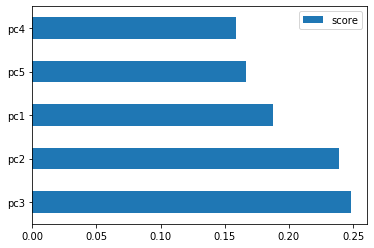

In [153]:
#gain = average training loss reduction gain when using feature to split
feature_important = xgb.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
values_wgt = list(map(lambda x: x/ sum(values), values))

data = pd.DataFrame(data=values_wgt, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

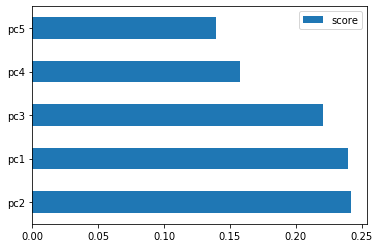

In [150]:
#cover = number of times feature is split across all trees taking into account proportion of samples going into the split
feature_important = xgb.get_booster().get_score(importance_type='cover')
keys = list(feature_important.keys())
values = list(feature_important.values())
values_wgt = list(map(lambda x: x/ sum(values), values))

data = pd.DataFrame(data=values_wgt, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

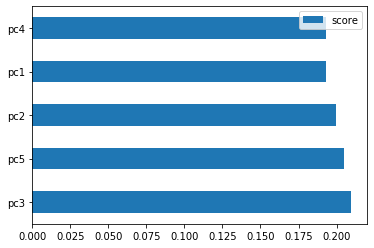

In [151]:
#weight = number of times feature is split across all trees
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
values_wgt = list(map(lambda x: x/ sum(values), values))

data = pd.DataFrame(data=values_wgt, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

In [96]:
# vc = VotingClassifier(estimators = [("LGB",lgb),('CBC',cbc),('XGB',xgb)],voting='soft')
# vc = vc.fit(X_train_pca,y_train)

# vc_csv = cross_val_score(estimator = vc, X = X_train_pca, y = y_train, cv = 10)
# vc_csv.mean()

In [97]:
# y_pred = vc.predict(X_test_pca).astype(int)

NameError: name 'vc' is not defined

In [ ]:
X_test['TARGET'] = y_pred
y_test = X_test[['SK_ID_CURR','TARGET']]

In [ ]:
y_test.to_csv('sample_submit.csv',index=False)

#### With outliers

In [ ]:
lgb_outlier = LGBMClassifier()

LGB_cvs_outlier = cross_val_score(estimator = lgb_outlier, X = X_train_outlier_pca, y = y_train_outlier, scoring='accuracy', cv = 10)
LGB_cvs_outlier.mean()

In [ ]:
y_train.shape

In [ ]:
# cbc_outlier = CatBoostClassifier()

# CBC_cvs_outlier = cross_val_score(estimator = cbc_outlier, X = X_train_outlier_pca, y = y_train_outlier, scoring='accuracy', cv = 10)
# CBC_cvs_outlier.mean()

In [ ]:
xgb_outlier = XGBClassifier(tree_method = 'hist',label_encoder=False)

XGB_cvs_outlier = cross_val_score(estimator = xgb_outlier, X = X_train_outlier_pca, y = y_train_outlier, cv = 10)
XGB_cvs_outlier.mean()

In [ ]:
# vc_outlier = VotingClassifier(estimators = [("LGB",lgb_outlier),('CBC',cbc_outlier),('XGB',xgb_outlier)],voting='soft')
# vc_outlier = vc_outlier.fit(X_train_outlier_pca,y_train_outlier)

# vc_csv_outlier = cross_val_score(estimator = vc, X = X_train_outlier_pca, y = y_train_outlier, cv = 10)
# vc_csv_outlier.mean()

In [ ]:
y_pred_outlier = vc.predict(X_test_outlier_pca).astype(int)

In [ ]:
X_test_outlier['TARGET'] = y_pred_outlier
y_test_outlier = X_test_outlier[['SK_ID_CURR','TARGET']]

In [ ]:
y_test_outlier.to_csv('sample_submit_outliers.csv',index=False)

#### Important features

In [ ]:
lgb_imp = LGBMClassifier()

LGB_cvs_imp = cross_val_score(estimator = lgb_imp, X = X_train_imp_drop, y = y_train, scoring='accuracy', cv = 10)
LGB_cvs_imp.mean()

In [ ]:
# cbc_imp = CatBoostClassifier()

# CBC_cvs_imp = cross_val_score(estimator = cbc_imp, X = X_train_imp_drop, y = y_train, scoring='accuracy', cv = 10)
# CBC_cvs_imp.mean()

In [98]:
xgb_imp = XGBClassifier(tree_method = 'hist',label_encoder=False)

XGB_cvs_imp = cross_val_score(estimator = xgb_imp, X = X_train_imp_drop, y = y_train, cv = 10)
XGB_cvs_imp.mean()

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.9190587538563753

In [102]:
xgb_imp.fit(X_train_imp,y_train)

[15:13:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:13:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              label_encoder=False, learning_rate=0.300000012, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              validate_parameters=1, verbosity=None)

In [ ]:
# ‘weight’: the number of times a feature is used to split the data across all trees.
# ‘gain’: the average gain across all splits the feature is used in.
# ‘cover’: the average coverage across all splits the feature is used in.
# ‘total_gain’: the total gain across all splits the feature is used in.
# ‘total_cover’: the total coverage across all splits the feature is used in.

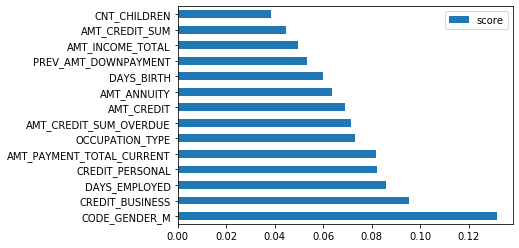

In [158]:
#gain = average training loss reduction gain when using feature to split
feature_important = xgb_imp.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
values_wgt = list(map(lambda x: x/ sum(values), values))

data = pd.DataFrame(data=values_wgt, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

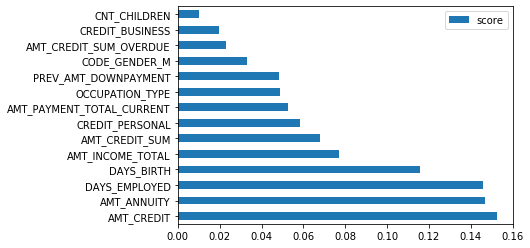

In [159]:
#total_gain = total training loss reduction gain when using feature to split
feature_important = xgb_imp.get_booster().get_score(importance_type='total_gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
values_wgt = list(map(lambda x: x/ sum(values), values))

data = pd.DataFrame(data=values_wgt, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

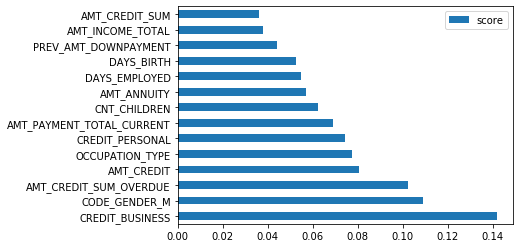

In [160]:
#cover = number of times feature is split across all trees taking into account proportion of samples going into the split
feature_important = xgb_imp.get_booster().get_score(importance_type='cover')
keys = list(feature_important.keys())
values = list(feature_important.values())
values_wgt = list(map(lambda x: x/ sum(values), values))

data = pd.DataFrame(data=values_wgt, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

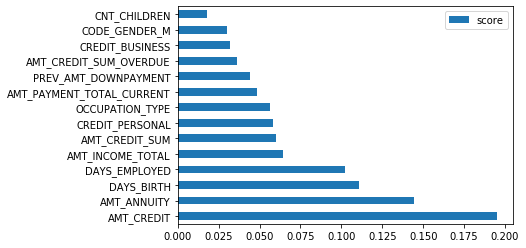

In [161]:
#total_cover = number of times feature is split across all trees taking into account proportion of samples going into the split
feature_important = xgb_imp.get_booster().get_score(importance_type='total_cover')
keys = list(feature_important.keys())
values = list(feature_important.values())
values_wgt = list(map(lambda x: x/ sum(values), values))

data = pd.DataFrame(data=values_wgt, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

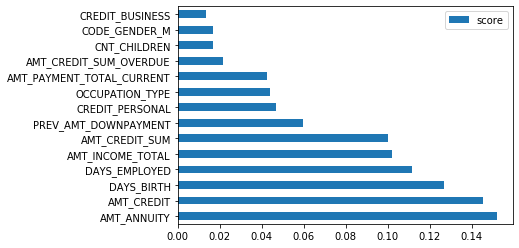

In [162]:
#weight = number of times feature is split across all trees
feature_important = xgb_imp.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
values_wgt = list(map(lambda x: x/ sum(values), values))

data = pd.DataFrame(data=values_wgt, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

<BarContainer object of 14 artists>

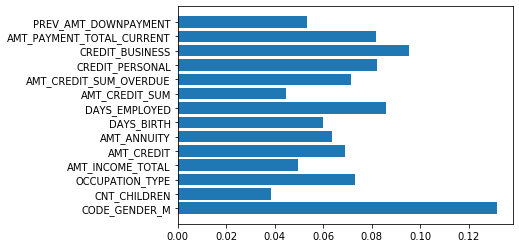

In [114]:
plt.barh(X_train_imp.columns,xgb_imp.feature_importances_)

In [ ]:
# vc_imp = VotingClassifier(estimators = [("LGB",lgb_imp),('CBC',cbc_imp),('XGB',xgb_imp)],voting='soft')
# vc_imp = vc_imp.fit(X_train_imp_drop,y_train)

# vc_csv_imp = cross_val_score(estimator = vc_imp, X = X_train_imp_drop, y = y_train, cv = 10)
# vc_csv_imp.mean()

In [ ]:
y_pred_imp = vc_imp.predict(X_test_imp_drop).astype(int)

In [ ]:
X_test['TARGET'] = y_pred_imp
y_test_imp = X_test[['SK_ID_CURR','TARGET']]

In [ ]:
y_test_imp.to_csv('sample_submit_imp.csv',index=False)

#### Conclusion on outliers and use of only important features

The outliers did not affect the data much since there were not many of them that got cleaned. Seems like using only the important features has not really improved the model itself.

#### FINAL REMARKS

Conclusion on model:
From the cross validation scores, we can identity that XGB and LightGBM perform best, with LightGBM being the optimal choice from the 3 algorithms. Using a voting classifier does not improve the overall performance much. Additional tuning of the models, experimentation as well as adding layers on top of the existing models for stacking or bagging may improve the model performance.


Ways to improve the model:
1. Further exploration of data to identity most importance features
    - Clustering of data to identify different client groups
    - Use of dimensionality reductionality to reduce noise
2. Experimentation of different variables doing A/B testing in the real world to pintpoint more important features.
3. Having better domain knowledge / user experience on this field will allow us to determine root causes through our expertise/experiences
4. Experimentation of different learning machine models and tuning the hyperparameters can improve the performance drastically (but we need to be weary of overfitting). Using Grid Search can speeden up the process
5. For buildling the model, we can add extra layers such as voting classifiers or stacking classifiers to improve the prediction and accuracy of the model.
6. Methodology in imputation of missing values and outliers analysis can be improved upon. If we can find different customer clusters, we can potentially provide a better imputation method and outliers analysis, as we have different groups of customers that each customer or loan data can be associated with.
7. Improvement in the data collection process, since we observed a lot of null values. By doing this, the model will become more accurate and we will not have to introduce as much bias in the imputation stage
